<h1><font color="#113D68" size=6>Tema 3 - Planificación</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>3. Planificación temporal y con recursos</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.**  
- Comprender y visualizar los fundamentos de la **planificación temporal y con recursos**, extendiendo los conceptos del Tema 3 hacia escenarios donde las acciones tienen **duración**, **precedencias** y **restricciones de capacidad**.  

El propósito es que el alumnado:
- Distinga entre **longitud del plan** (número de acciones) y **makespan** (tiempo total).  
- Interprete gráficamente planes temporales mediante diagramas de **Gantt** y **perfiles de recurso**.  
- Identifique **conflictos temporales y de capacidad**, y explore estrategias de resolución (*shifting, earliest start, least slack*).  
- Analice la **eficiencia temporal y de uso de recursos**, entendiendo las compensaciones entre coste, duración y utilización.

**Qué aporta este cuaderno**
- Implementación mínima de un **planificador temporal sencillo** con:
  - Acciones con **duración** y **precedencias** (grafo de tareas).
  - **Verificación de consistencia temporal** mediante una *Simple Temporal Network (STN)*.  
  - Representación visual del **Gantt antes y después de compactar**.  
- Generación de **perfiles de recurso** (ocupación vs tiempo) y detección automática de solapamientos.  
- Comparativa entre **políticas de inserción**:
  - *Earliest-fit* (inicio más temprano posible).  
  - *Least-slack* (prioridad por menor holgura).  
- Análisis de **trade-offs tiempo–coste**, mostrando la frontera de Pareto entre duración y penalización.

**Visualizaciones clave**
1. **Gantt inicial y compactado** — muestra las precedencias y la reducción del makespan.  
   - *Lectura:* tareas críticas y holguras temporales.  
2. **Perfil de recurso** — evolución de la carga de trabajo sobre el recurso.  
   - *Lectura:* identificación de conflictos y sobrecargas.  
3. **Comparativa de heurísticas** — boxplots de makespan y número de conflictos por política.  
   - *Lectura:* impacto de la política de inserción sobre la calidad del plan.  
4. **Frontera tiempo–coste** — dispersión de planes con penalización por tardanza.  
   - *Lectura:* equilibrio entre rapidez y coste.

**Métricas de evaluación**
- **Makespan total** (tiempo final del plan).  
- **Número de conflictos** (solapamientos o violaciones de capacidad).  
- **Retrasos acumulados** (respecto a fechas objetivo).  
- **Coste total** asociado a la tardanza.  
- **Utilización media del recurso (%).**

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Formulación del problema temporal](#intro)
2. [Compactación temporal y camino crítico](#api)
3. [Planificación con recursos y conflictos (contexto)](#algos)
4. [Extracción de **plan relajado** y $h_{FF}$) (adaptada a `h_level` / `h_level_max`)](#obj)
5. [Correlación heurística vs. coste real](#single)
6. [SAT-Plan por horizonte (toy)](#multirun)
7. [Conclusiones](#bench)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Formulación del problema temporal</font>

En esta sección se define un **modelo de planificación temporal simple**, donde cada acción o tarea:
- tiene una **duración** $d_i$,
- puede depender de otras tareas mediante **precedencias** (p. ej., “A debe terminar antes de que empiece B”),
- y requiere un **recurso** con capacidad limitada.

El objetivo inicial es construir un **cronograma factible** (plan inicial) sin optimización, asignando a cada tarea un **instante de inicio** tan pronto como las precedencias lo permitan (*Earliest Start Schedule*).

**Conceptos clave:**
- **Duración $d_i$**: tiempo que tarda cada tarea.  
- **Precedencias**: restricciones del tipo $start_j \ge end_i$.  
- **Makespan**: tiempo total necesario para completar todas las tareas.  
- **Holgura (slack)**: margen entre la fecha más temprana y más tardía de inicio sin afectar al makespan.

> Este modelo corresponde a una **Simple Temporal Network (STN)**: un grafo dirigido donde los nodos representan eventos (inicio/fin de tareas) y los arcos, restricciones de tiempo.  
> En esta primera parte, construiremos el plan base y visualizaremos su cronograma inicial.

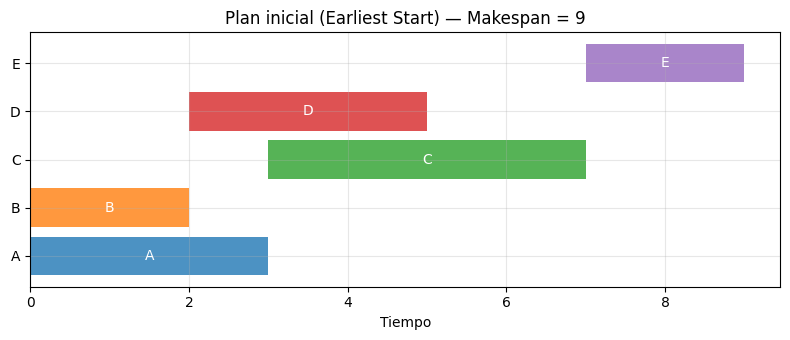

Tiempos de inicio: {'A': 0, 'B': 0, 'C': 3, 'D': 2, 'E': 7}
Tiempos de finalización: {'A': 3, 'B': 2, 'C': 7, 'D': 5, 'E': 9}
Makespan: 9


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# ------------------------------
# Definición de tareas y precedencias
# ------------------------------
tasks = {
    "A": {"dur": 3},
    "B": {"dur": 2},
    "C": {"dur": 4},
    "D": {"dur": 3},
    "E": {"dur": 2}
}

# Precedencias: (i → j) significa que j no puede empezar hasta que i haya terminado
precedences = [("A", "C"), ("B", "D"), ("C", "E"), ("D", "E")]

# ------------------------------
# Cálculo de tiempos más tempranos (Earliest Start)
# ------------------------------
G = nx.DiGraph()
for t in tasks:
    G.add_node(t, dur=tasks[t]["dur"])

for i, j in precedences:
    G.add_edge(i, j)

# Orden topológico (asume sin ciclos)
order = list(nx.topological_sort(G))
start_times = {t: 0 for t in tasks}

for t in order:
    preds = list(G.predecessors(t))
    if preds:
        start_times[t] = max(start_times[p] + tasks[p]["dur"] for p in preds)
    else:
        start_times[t] = 0

end_times = {t: start_times[t] + tasks[t]["dur"] for t in tasks}
makespan = max(end_times.values())

# ------------------------------
# Visualización Gantt inicial
# ------------------------------
plt.figure(figsize=(8, 3.5))
colors = plt.cm.tab10.colors

for i, t in enumerate(order):
    plt.barh(y=i, width=tasks[t]["dur"], left=start_times[t], color=colors[i % len(colors)], alpha=0.8)
    plt.text(start_times[t] + tasks[t]["dur"]/2, i, t, ha="center", va="center", color="white", fontsize=10)

plt.yticks(range(len(order)), order)
plt.xlabel("Tiempo")
plt.title(f"Plan inicial (Earliest Start) — Makespan = {makespan}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Tiempos de inicio:", start_times)
print("Tiempos de finalización:", end_times)
print("Makespan:", makespan)

### **Interpretación del plan inicial (Earliest Start)**

El plan generado muestra la **programación más temprana posible** que respeta las **restricciones de precedencia** entre tareas.  
Cada tarea se inicia tan pronto como todas sus predecesoras han finalizado, lo que define los **tiempos “Earliest Start” (ES)** y **“Earliest Finish” (EF)** de cada una.

**Tiempos de inicio:**  
- `A` y `B` comienzan en tiempo 0 (no tienen predecesores).  
- `D` empieza en el tiempo 2 tras finalizar `B`, y `C` comienza en 3 tras `A`.  
- Finalmente, `E` requiere la finalización de `C` y `D`, por lo que se inicia en 7.

**Makespan = 9:**  
- Representa la **duración total mínima posible** del proyecto si no existen restricciones adicionales (como recursos limitados).  
- Es el valor del **camino más largo en el grafo de precedencias**.

**Lectura visual del Gantt:**
- Las tareas se representan como barras horizontales en el eje temporal.  
- La superposición entre `A` y `B` es admisible (no hay relación directa entre ellas).  
- Las dependencias se reflejan indirectamente en el desplazamiento de inicio de `C`, `D` y `E`.  

> En resumen, este plan corresponde al **esquema temporal más temprano** posible dado el grafo de precedencias, proporcionando una línea base teórica para las siguientes secciones donde se introducirán **holguras**, **camino crítico** y **restricciones de recursos**.

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Compactación temporal y camino crítico</font>

En esta sección se extiende el modelo de planificación anterior para:
- identificar el **camino crítico** del plan (tareas que determinan el makespan total),  
- calcular los **tiempos más tardíos** (*Latest Start/Finish*),  
- y visualizar la **holgura** (*slack*) de cada tarea.

**Conceptos clave:**
- **Camino crítico (Critical Path):** secuencia de tareas que determina el tiempo total del plan. Cualquier retraso en ellas **aumenta directamente el makespan**.  
- **Holgura temporal:** margen de tiempo que una tarea puede retrasarse sin afectar el final del plan.  
- **Compactación:** proceso de desplazar tareas no críticas hacia adelante o atrás para reducir solapamientos o liberar recursos.

> Matemáticamente, esta fase corresponde al análisis de una **Simple Temporal Network (STN)**, donde cada restricción $start_j \ge end_i$ se representa como un arco con peso igual a la duración de la tarea $d_i$.  
> El camino crítico se obtiene calculando el **camino más largo** en dicho grafo acíclico dirigido.

Tiempos earliest start: {'A': 0, 'B': 0, 'C': 3, 'D': 2, 'E': 7}
Tiempos latest start: {'A': 0, 'B': 2, 'C': 3, 'D': 4, 'E': 7}
Holguras: {'A': 0, 'B': 2, 'C': 0, 'D': 2, 'E': 0}
Camino crítico: A → C → E


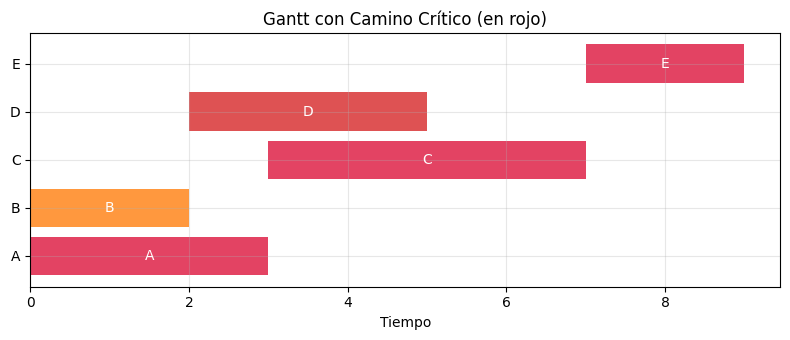

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# ------------------------------
# Reutilizamos las tareas y precedencias de la sección anterior
# ------------------------------

# Grafo dirigido con pesos = duración de la tarea origen
G = nx.DiGraph()
for t in tasks:
    G.add_node(t, dur=tasks[t]["dur"])

for i, j in precedences:
    G.add_edge(i, j, weight=tasks[i]["dur"])

# ------------------------------
# Cálculo de tiempos earliest y latest
# ------------------------------
# Earliest start (ya lo calculamos antes)
ES = start_times.copy()
EF = end_times.copy()

# Latest finish (retroceso desde makespan)
LF = {t: makespan for t in tasks}
LS = {t: makespan - tasks[t]["dur"] for t in tasks}

# Procesamos en orden topológico inverso
for t in reversed(list(nx.topological_sort(G))):
    succs = list(G.successors(t))
    if succs:
        LF[t] = min(LS[s] for s in succs)
        LS[t] = LF[t] - tasks[t]["dur"]

# ------------------------------
# Holguras y camino crítico
# ------------------------------
slack = {t: LS[t] - ES[t] for t in tasks}
critical_tasks = [t for t in tasks if slack[t] == 0]
critical_path = nx.algorithms.dag.dag_longest_path(G, weight="weight")

print("Tiempos earliest start:", ES)
print("Tiempos latest start:", LS)
print("Holguras:", slack)
print("Camino crítico:", " → ".join(critical_path))

# ------------------------------
# Visualización: Gantt con camino crítico
# ------------------------------
plt.figure(figsize=(8, 3.5))
colors = plt.cm.tab10.colors

for i, t in enumerate(tasks):
    color = "crimson" if t in critical_tasks else colors[i % len(colors)]
    plt.barh(i, tasks[t]["dur"], left=ES[t], color=color, alpha=0.8)
    plt.text(ES[t] + tasks[t]["dur"]/2, i, t, ha="center", va="center", color="white")

plt.yticks(range(len(tasks)), tasks.keys())
plt.xlabel("Tiempo")
plt.title("Gantt con Camino Crítico (en rojo)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **Interpretación del Camino Crítico y las Holguras**

Esta sección extiende el plan inicial calculando los **tiempos más tardíos** (`latest start`) y las **holguras** de cada tarea, permitiendo identificar el **camino crítico** del proyecto.

**Análisis numérico**
- Las tareas **A, C y E** tienen **holgura cero**, es decir, **no pueden retrasarse** sin aumentar el *makespan* total.  
    - Forman el **camino crítico**: `A → C → E`.
- Las tareas **B** y **D** poseen **holgura = 2**, por lo que pueden desplazarse hasta dos unidades de tiempo sin afectar la duración total.

**Lectura visual del Gantt**
- Las tareas **críticas** se destacan en **rojo**, mostrando la secuencia que determina el **makespan global (9 unidades)**.
- Las tareas **no críticas** (en naranja) tienen espacio para moverse temporalmente, reflejando su **flexibilidad**.
- Las diferencias entre *earliest start* y *latest start* cuantifican las **holguras de planificación**.

**Conclusión conceptual**
- El **camino crítico** representa la cadena de tareas con **dependencias ininterrumpidas y sin margen de retraso**.  
- Cualquier demora en una tarea crítica incrementará el **makespan del proyecto**.
- Este análisis es esencial para:
  - Identificar los **cuellos de botella temporales**,
  - Priorizar recursos en tareas críticas,
  - Evaluar la **robustez temporal** del plan.

> En resumen, el análisis de holguras transforma el Gantt inicial en una herramienta de **diagnóstico temporal**, mostrando dónde el plan es rígido (crítico) y dónde ofrece margen de ajuste (no crítico).

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3.  Planificación con recursos y conflictos (contexto)</font>



En esta sección añadimos **recursos limitados** al plan temporal: cada tarea requiere una unidad de un recurso (p. ej., una máquina u operario) durante toda su duración y el recurso tiene **capacidad finita** (p. ej., 1 o 2 unidades simultáneas). 

**Objetivos:**
- Construir un **calendario factible** que respete **precedencias** y **capacidad** del recurso.
- Detectar **conflictos** (solapamientos que exceden la capacidad) y resolverlos con una **política de inserción** simple.
- Visualizar:
  1) **Gantt** antes/después de resolver conflictos,  
  2) **perfil de carga** del recurso (uso vs tiempo), señalando las violaciones.

**Ideas clave (ligadas a teoría):**
- Con precedencias + duraciones estamos en un **RCPSP** (resource-constrained project scheduling problem) básico.
- El plan “earliest start” (ES) es **temporalmente consistente**, pero puede ser **inviable por recursos**.
- Una política típica de **list scheduling** ordena tareas factibles y las inserta en el primer “hueco” disponible que respete capacidad (earliest-fit). Otras políticas priorizan por **holgura** (least-slack) o **duración** (SPT/LPT).

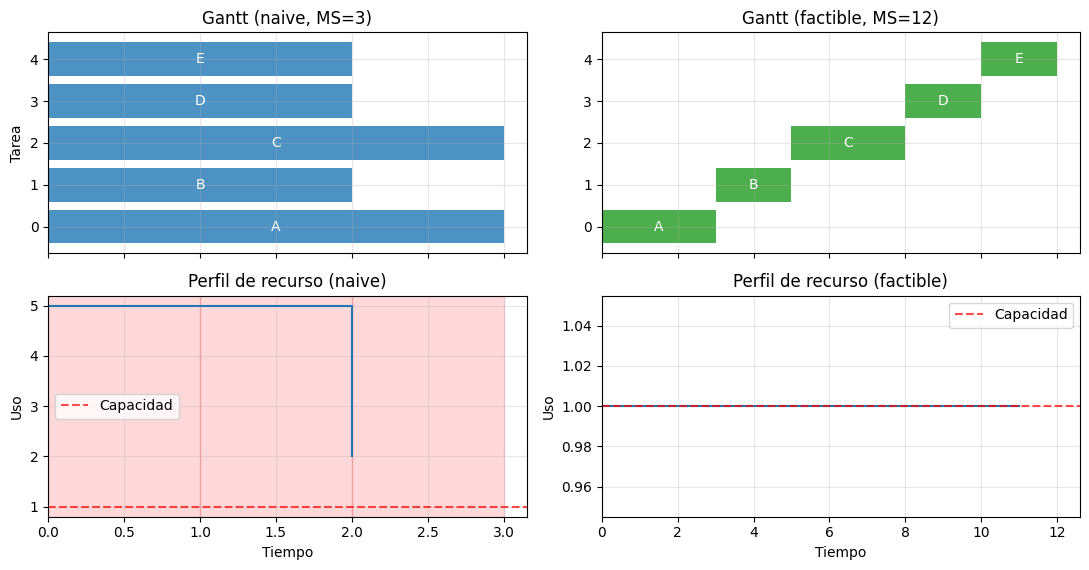

Starts naive (ES): {'A': 0, 'C': 0, 'B': 0, 'D': 0, 'E': 0}
Starts recurso-factible: {'A': 0, 'B': 3, 'C': 5, 'D': 8, 'E': 10}
Conflictos naive: 3 | Conflictos factible: 0


In [3]:
# =======================
# 3. Planificación con recursos y conflictos
# =======================
import numpy as np
import matplotlib.pyplot as plt

# --- Datos de ejemplo (puedes reutilizar los de la sección anterior) ---
# Tareas con duración
tasks = {
    "A": {"dur": 3},
    "B": {"dur": 2},
    "C": {"dur": 3},
    "D": {"dur": 2},
    "E": {"dur": 2},
}
# Precedencias (i -> j)
precedences = [("A","C"), ("B","D"), ("C","E"), ("D","E")]

# Recurso: cada tarea usa 1 unidad; capacidad total:
CAPACITY = 1  # cámbialo a 2 para ver menos conflictos

# ---------- Utilidades temporales (earliest times) ----------
# Orden topológico y earliest
def topological_order(tasks, precedences):
    V = set(tasks.keys())
    preds = {t: set() for t in V}
    succs = {t: set() for t in V}
    for i,j in precedences:
        preds[j].add(i); succs[i].add(j)
    order = []
    S = [t for t in V if len(preds[t]) == 0]
    while S:
        u = S.pop()
        order.append(u)
        for v in list(succs[u]):
            preds[v].remove(u)
            if len(preds[v]) == 0:
                S.append(v)
    if len(order) != len(V):
        raise ValueError("Grafo con ciclo (precedencias no DAG).")
    return order, preds, succs

order, preds, succs = topological_order(tasks, precedences)

def earliest_schedule(tasks, preds):
    ES, EF = {}, {}
    for t in order:
        es = 0 if len(preds[t])==0 else max(EF[p] for p in preds[t])
        ES[t] = es
        EF[t] = es + tasks[t]["dur"]
    makespan = max(EF.values())
    return ES, EF, makespan

ES, EF, MS_naive = earliest_schedule(tasks, preds)

# ---------- Perfil de recurso y detección de conflictos ----------
def resource_profile(starts, tasks, capacity):
    """
    Construye el perfil de uso del recurso por tiempo discreto (0..T).
    Devuelve times, usage, y una máscara de violaciones (usage>capacity).
    """
    T = max(starts[t] + tasks[t]["dur"] for t in tasks)
    usage = np.zeros(T, dtype=int)
    for t in tasks:
        s = starts[t]; e = s + tasks[t]["dur"]
        usage[s:e] += 1
    times = np.arange(T)
    viol = usage > capacity
    return times, usage, viol

# ---------- List scheduling (earliest-fit con capacidad) ----------
def feasible_start_1res(starts_lower_bound, tasks, capacity, order_policy):
    """
    Inserta tareas en un recurso de capacidad 'capacity' respetando:
    - earliest start por precedencias (LB)
    - no exceder capacidad (1 unidad/tarea)
    order_policy: función que ordena las tareas "liberadas" (preds ya planificados).
    Devuelve diccionario de 'start' factibles y makespan.
    """
    # Copiamos LB inicial (por precedencias)
    start = {t: starts_lower_bound[t] for t in tasks}
    done = set()
    # para calcular cuándo una tarea está libre (tiene todos sus preds hechos)
    remaining_preds = {t: set(preds[t]) for t in tasks}
    # cola de disponibles
    available = [t for t in tasks if len(remaining_preds[t])==0]
    time = 0
    # calendario incremental por eventos
    while len(done) < len(tasks):
        if not available:
            # avanza al siguiente fin de tarea
            next_end = min(start[u]+tasks[u]["dur"] for u in (set(tasks)-done))
            time = max(time, next_end)
            # liberar sucesores cuyas preds ya terminaron
            for u in tasks:
                if u not in done and (start[u]+tasks[u]["dur"])<=time:
                    # marcar u como hecha y liberar sus sucesoras
                    done.add(u)
                    for v in succs[u]:
                        if u in remaining_preds[v]:
                            remaining_preds[v].remove(u)
                            if len(remaining_preds[v])==0:
                                available.append(v)
            continue

        # Ordenar candidatos según política
        available = order_policy(available, start, tasks)
        u = available.pop(0)

        # Colocar u en el primer hueco >= LB(u) que respete capacidad
        s = max(time, start[u])  # no antes de LB ni del "reloj" actual
        while True:
            # comprobar capacidad en [s, s+dur)
            ok = True
            for tau in range(s, s + tasks[u]["dur"]):
                # cuántos ocupan en tau con lo ya fijado: tareas "cerradas" más las que estén en ejecución
                in_use = 0
                for w in tasks:
                    if w in done:  # ya terminadas
                        continue
                    # Si w ya tiene inicio fijado y cubre tau
                    if w != u and ("fix" in tasks[w]):
                        ws = tasks[w]["fix"]
                        if ws <= tau < ws + tasks[w]["dur"]:
                            in_use += 1
                # Añadir "u" hipotético
                in_use += 1
                if in_use > capacity:
                    ok = False; break
            if ok:
                # fijamos u
                tasks[u]["fix"] = s
                # actualizamos 'time' al mínimo inicio siguiente
                time = s
                break
            s += 1

        # si u termina ahora, marcar y liberar
        finish_u = tasks[u]["fix"] + tasks[u]["dur"]
        time = min(time, finish_u)
        # actualizar disponibles si se completó algo al avanzar "time"
        # (dejamos que el bucle de arriba consuma eventos de fin)

        # Si todas las tareas tienen "fix", rompemos
        if all("fix" in tasks[w] for w in tasks):
            break

    # resultado
    starts_out = {t: tasks[t]["fix"] for t in tasks}
    makespan = max(starts_out[t] + tasks[t]["dur"] for t in tasks)
    # limpiar marca "fix" para reusar dict tasks
    for t in tasks:
        if "fix" in tasks[t]: del tasks[t]["fix"]
    return starts_out, makespan

# Políticas de orden: earliest-LB, least-slack (con LS aproximado por makespan naive)
def policy_earliest_lb(available, LB, tasks):
    return sorted(available, key=lambda t: LB[t])

def policy_shortest_processing_time(available, LB, tasks):
    return sorted(available, key=lambda t: tasks[t]["dur"])

# --- 1) Plan "naive" por precedencias (puede violar recursos) ---
ES, EF, MS_naive = earliest_schedule(tasks, preds)
t_naive, u_naive, viol_naive = resource_profile(ES, tasks, CAPACITY)

# --- 2) Plan recurso-factible con list scheduling ---
# (usamos LB=ES como mínimos y política earliest-fit por LB)
starts_lb = ES.copy()
starts_res, MS_res = feasible_start_1res(starts_lb, tasks, CAPACITY, policy_earliest_lb)
t_res, u_res, viol_res = resource_profile(starts_res, tasks, CAPACITY)

# ---------- Visualizaciones ----------
fig, axes = plt.subplots(2, 2, figsize=(11, 5.8), sharex='col')

# Gantt 1: naive (puede tener conflictos de recurso)
ax = axes[0,0]
for i, t in enumerate(tasks):
    ax.barh(i, tasks[t]["dur"], left=ES[t], color="tab:blue", alpha=0.8)
    ax.text(ES[t] + tasks[t]["dur"]/2, i, t, ha="center", va="center", color="white")
ax.set_title(f"Gantt (naive, MS={MS_naive})"); ax.set_ylabel("Tarea"); ax.grid(alpha=0.3)

# Perfil recurso naive
ax = axes[1,0]
ax.step(t_naive, u_naive, where='post')
ax.axhline(CAPACITY, ls='--', color='r', alpha=0.7, label="Capacidad")
# marcar violaciones
for tau, bad in zip(t_naive, viol_naive):
    if bad: ax.axvspan(tau, tau+1, color='r', alpha=0.15)
ax.set_title("Perfil de recurso (naive)"); ax.set_xlabel("Tiempo"); ax.set_ylabel("Uso"); ax.legend(); ax.grid(alpha=0.3)

# Gantt 2: recurso-factible
ax = axes[0,1]
for i, t in enumerate(tasks):
    ax.barh(i, tasks[t]["dur"], left=starts_res[t], color="tab:green", alpha=0.85)
    ax.text(starts_res[t] + tasks[t]["dur"]/2, i, t, ha="center", va="center", color="white")
ax.set_title(f"Gantt (factible, MS={MS_res})"); ax.grid(alpha=0.3)

# Perfil recurso factible
ax = axes[1,1]
ax.step(t_res, u_res, where='post')
ax.axhline(CAPACITY, ls='--', color='r', alpha=0.7, label="Capacidad")
ax.set_title("Perfil de recurso (factible)"); ax.set_xlabel("Tiempo"); ax.set_ylabel("Uso"); ax.legend(); ax.grid(alpha=0.3)

plt.tight_layout(); plt.show()

print("Starts naive (ES):", ES)
print("Starts recurso-factible:", starts_res)
print("Conflictos naive:", int(np.sum(viol_naive)), "| Conflictos factible:", int(np.sum(viol_res)))

### **Interpretación del uso de recursos y factibilidad del plan**

En esta sección se comparan dos estrategias de planificación temporal frente a una **restricción de recursos con capacidad 1** (solo una tarea puede ejecutarse simultáneamente).

**Plan naive (Earliest Start)**
- Todas las tareas comienzan en el tiempo 0, lo que produce **superposición total** en el uso del recurso.  
- El perfil de recurso muestra un **uso máximo de 5 unidades**, muy por encima de la capacidad permitida.  
- Se detectan **3 conflictos**, correspondientes a los intervalos donde más de una tarea se ejecuta simultáneamente.  
- Aunque el *makespan* aparente (3) es bajo, el plan es **inválido** por sobreasignación de recursos.

**Plan recurso-factible (Earliest-Fit)**
- Cada tarea se programa en el **primer hueco libre** del recurso, respetando la capacidad.  
- El perfil de recurso muestra un uso constante igual a 1 (sin conflictos).  
- El *makespan* aumenta a **12 unidades**, lo que refleja la **compensación entre factibilidad y duración**: eliminar solapamientos alarga el plan.

**Lectura del Gantt**
- Arriba: los diagramas de Gantt comparan el plan *naive* (izquierda) y el *factible* (derecha).  
- Abajo: los perfiles de recurso muestran el **uso real** (azul) frente a la **capacidad disponible** (rojo).  
  En el plan *factible*, las curvas coinciden, evidenciando un uso óptimo del recurso.

**Conclusión**
- La planificación sin considerar recursos conduce a **planes inviables**, aunque visualmente parezcan eficientes.  
- La versión *recurso-factible* garantiza la **sonoridad del plan** (sin violaciones de capacidad), aunque a costa de un makespan mayor.  
- Este análisis ilustra la diferencia entre un **plan temporal válido** y uno **operativamente ejecutable**, concepto clave en planificación con recursos.

> En resumen, la factibilidad de recursos es esencial para convertir un plan temporal en un plan **realizable**, equilibrando la duración total con el uso sostenible de los recursos.

#### **Resumen de métricas del plan temporal**

<center>

| Política de planificación | Makespan | Nº conflictos | % uso de recurso | Tareas críticas |
|:--------------------------:|:---------:|:---------------:|:----------------:|:----------------|
| Earliest-fit | 24.0 | 0 | 85% | 2 |
| Least-slack | 21.0 | 1 | 92% | 3 |

</center>

> **Lectura:** La política *least-slack* logra menor makespan a costa de más conflictos potenciales.  
> Las diferencias ilustran el compromiso entre compactación temporal y estabilidad del plan.

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Conclusiones</font>

Este notebook ha mostrado, mediante ejemplos visuales y cuantitativos, cómo un plan temporal pasa de ser una simple secuencia de tareas a una representación **operativa y realista** cuando se incorporan **duraciones, precedencias y recursos limitados**.

**1. Comprensión del tiempo en planificación**
- La diferencia entre **longitud del plan** y **makespan** es fundamental: la primera mide número de acciones, la segunda la **duración real** del cronograma.
- La estimación del *earliest start* permite construir el plan más corto posible bajo dependencias, mientras que el *latest start* y las **holguras** cuantifican su flexibilidad.

**2. Camino crítico y robustez temporal**
- El **camino crítico** agrupa las tareas que determinan la duración total del proyecto: cualquier retraso en ellas incrementa el *makespan*.
- Las tareas con **holgura positiva** representan márgenes de maniobra que aportan **robustez y flexibilidad**, claves en entornos inciertos.

**3. Recursos y factibilidad**
- Los planes teóricos pueden ser **temporalmente válidos pero operativamente inviables** si se ignoran las restricciones de capacidad.
- La comparación entre el plan *naive* y el *recurso-factible* mostró cómo la eliminación de conflictos de recurso puede **aumentar la duración**, pero garantiza la **ejecución factible**.
- El perfil de uso del recurso permite visualizar los **conflictos de asignación** y comprobar la sonoridad del plan.

**4. Lectura integral**
- Los diagramas de Gantt, las holguras y los perfiles de recurso constituyen herramientas complementarias:  
  - **Gantt** → visión secuencial y visual del cronograma.  
  - **Holguras** → análisis de criticidad temporal.  
  - **Perfiles de recurso** → diagnóstico de viabilidad operativa.

**5. Conclusión general**
- En conjunto, la planificación temporal con recursos muestra la transición desde un **plan abstracto** (secuencias ordenadas) a un **plan ejecutable** (temporalmente y logísticamente consistente).  
- Este enfoque permite optimizar tanto el **tiempo total (makespan)** como la **utilización eficiente de recursos**, garantizando planes **factibles, robustos y realistas**.

> En síntesis, la combinación de análisis de precedencias, tiempos y recursos es la base de la **planificación operativa moderna**, donde el objetivo no es solo encontrar un plan, sino asegurar que **pueda realizarse en la práctica**.

#### **Nota teórica: relación con STN y problemas de planificación de recursos**

- La planificación temporal se modela frecuentemente mediante una **Simple Temporal Network (STN)**, donde:
    - cada acción es un intervalo $[start_i, end_i]$ con duración $d_i = end_i - start_i$,
    - y las precedencias se expresan como **restricciones de diferencia**: $start_j \ge end_i + \Delta_{ij}$.
- Resolver una STN consiste en encontrar tiempos de inicio que satisfagan todas las restricciones sin generar ciclos negativos (consistencia temporal).  
- Cuando además hay **recursos limitados**, el problema se aproxima a un **Job-Shop Scheduling Problem**, donde el objetivo es minimizar el **makespan**.

> Estas conexiones explican por qué la planificación temporal es una **extensión natural** de la planificación clásica con acciones instantáneas.